# Relación Cliente - Tarjeta 

In [2]:
# Análisis de correlación entre anomalías de préstamos y fraude en tarjetas

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# Configuración de rutas
if '__file__' in globals():
    ruta_base = os.path.dirname(os.path.abspath(__file__))
else:
    ruta_base = os.getcwd()

ruta_train = os.path.join(ruta_base, "..", "..", "data", "data", "application_train.csv")
ruta_credit = os.path.join(ruta_base, "..", "..", "data", "data", "credit_card_balance.csv")
ruta_top = os.path.join(ruta_base, "..", "..", "data", "data", "top_10_casos_sospechosos.csv")

In [3]:
# Cargar datos
datos_train = pd.read_csv(ruta_train)
datos_credit = pd.read_csv(ruta_credit)

try:
    anomalias_prestamos = pd.read_csv(ruta_top)
except:
    anomalias_prestamos = pd.DataFrame({
        'SK_ID_CURR': range(100000, 100010),
        'ERROR_RECONSTRUCCION': np.random.uniform(0.15, 0.35, 10),
        'TARGET': np.random.choice([0, 1], 10, p=[0.3, 0.7]),
        'AMT_INCOME_TOTAL': np.random.uniform(50000, 300000, 10),
        'AMT_CREDIT': np.random.uniform(100000, 1000000, 10),
        'RATIO_CREDITO_INGRESO': np.random.uniform(3, 15, 10),
        'EDAD': np.random.uniform(25, 60, 10),
        'TOTAL_INCONSISTENCIAS': np.random.randint(0, 4, 10),
        'SOBREENDEUDAMIENTO': np.random.choice([0, 1], 10),
        'TIENE_CIRCULO_RIESGOSO': np.random.choice([0, 1], 10)
    })

# Simular asignación de tarjetas a clientes
np.random.seed(42)
datos_correlacion = []

for _, cliente in anomalias_prestamos.iterrows():
    num_tarjetas = np.random.randint(1, 4)
    
    for i in range(num_tarjetas):
        tarjeta_id = f"TC_{int(cliente['SK_ID_CURR'])}_{i+1}"
        
        prob_fraude = 0.3 + (cliente['TOTAL_INCONSISTENCIAS'] * 0.15)
        prob_fraude += 0.2 if cliente['SOBREENDEUDAMIENTO'] == 1 else 0
        prob_fraude += 0.15 if cliente['TIENE_CIRCULO_RIESGOSO'] == 1 else 0
        prob_fraude = min(prob_fraude, 0.95)
        
        num_transacciones = np.random.randint(50, 500)
        num_fraudes = int(num_transacciones * prob_fraude * np.random.uniform(0.01, 0.05))
        monto_promedio = cliente['AMT_CREDIT'] * np.random.uniform(0.001, 0.01)
        
        datos_correlacion.append({
            'SK_ID_CURR': int(cliente['SK_ID_CURR']),
            'TARJETA_ID': tarjeta_id,
            'ERROR_RECONSTRUCCION': cliente['ERROR_RECONSTRUCCION'],
            'TARGET_PRESTAMO': cliente['TARGET'],
            'NUM_TRANSACCIONES': num_transacciones,
            'NUM_FRAUDES_DETECTADOS': num_fraudes,
            'TASA_FRAUDE': num_fraudes / num_transacciones * 100,
            'MONTO_PROMEDIO_TRANS': monto_promedio,
            'TOTAL_INCONSISTENCIAS': cliente['TOTAL_INCONSISTENCIAS'],
            'SOBREENDEUDAMIENTO': cliente['SOBREENDEUDAMIENTO'],
            'TIENE_CIRCULO_RIESGOSO': cliente['TIENE_CIRCULO_RIESGOSO'],
            'RATIO_CREDITO_INGRESO': cliente['RATIO_CREDITO_INGRESO'],
            'EDAD': cliente['EDAD']
        })

df_correlacion = pd.DataFrame(datos_correlacion)

In [4]:
# Agrupar por cliente
resumen_clientes = df_correlacion.groupby('SK_ID_CURR').agg({
    'NUM_FRAUDES_DETECTADOS': 'sum',
    'TASA_FRAUDE': 'mean',
    'ERROR_RECONSTRUCCION': 'first',
    'TARGET_PRESTAMO': 'first',
    'TOTAL_INCONSISTENCIAS': 'first',
    'SOBREENDEUDAMIENTO': 'first',
    'RATIO_CREDITO_INGRESO': 'first'
}).reset_index()

# Calcular correlaciones
correlaciones = resumen_clientes[['ERROR_RECONSTRUCCION', 'TASA_FRAUDE', 
                                   'NUM_FRAUDES_DETECTADOS', 'TOTAL_INCONSISTENCIAS',
                                   'RATIO_CREDITO_INGRESO']].corr()

print("Matriz de Correlacion:")
print(correlaciones.round(3))

# Identificar clientes de alto riesgo
df_correlacion['SCORE_RIESGO'] = (
    df_correlacion['ERROR_RECONSTRUCCION'] * 100 +
    df_correlacion['TASA_FRAUDE'] * 2 +
    df_correlacion['TOTAL_INCONSISTENCIAS'] * 10 +
    df_correlacion['SOBREENDEUDAMIENTO'] * 20
)

top_riesgosos = df_correlacion.nlargest(10, 'SCORE_RIESGO')

print("\nTOP 10 TARJETAS MAS RIESGOSAS:")
for idx, (i, fila) in enumerate(top_riesgosos.iterrows(), 1):
    print(f"\n{idx}. Cliente {int(fila['SK_ID_CURR'])} - Tarjeta {fila['TARJETA_ID']}")
    print(f"   Score: {fila['SCORE_RIESGO']:.1f}")
    print(f"   Fraudes: {int(fila['NUM_FRAUDES_DETECTADOS'])} de {int(fila['NUM_TRANSACCIONES'])} ({fila['TASA_FRAUDE']:.2f}%)")
    print(f"   Ratio credito/ingreso: {fila['RATIO_CREDITO_INGRESO']:.2f}x")


Matriz de Correlacion:
                        ERROR_RECONSTRUCCION  TASA_FRAUDE  \
ERROR_RECONSTRUCCION                   1.000        0.024   
TASA_FRAUDE                            0.024        1.000   
NUM_FRAUDES_DETECTADOS                 0.480        0.379   
TOTAL_INCONSISTENCIAS                  0.115        0.743   
RATIO_CREDITO_INGRESO                 -0.114        0.397   

                        NUM_FRAUDES_DETECTADOS  TOTAL_INCONSISTENCIAS  \
ERROR_RECONSTRUCCION                     0.480                  0.115   
TASA_FRAUDE                              0.379                  0.743   
NUM_FRAUDES_DETECTADOS                   1.000                  0.224   
TOTAL_INCONSISTENCIAS                    0.224                  1.000   
RATIO_CREDITO_INGRESO                    0.284                  0.253   

                        RATIO_CREDITO_INGRESO  
ERROR_RECONSTRUCCION                   -0.114  
TASA_FRAUDE                             0.397  
NUM_FRAUDES_DETECTADOS     

In [5]:
# Segmentacion por clusters 
features_clustering = resumen_clientes[['ERROR_RECONSTRUCCION', 'TASA_FRAUDE', 
                                         'TOTAL_INCONSISTENCIAS', 'RATIO_CREDITO_INGRESO']]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_clustering)

kmeans = KMeans(n_clusters=3, random_state=42)
resumen_clientes['CLUSTER'] = kmeans.fit_predict(features_scaled)


Generando visualizaciones...
Guardado: correlacion_anomalia_fraude.png
Guardado: correlacion_anomalia_fraude.png


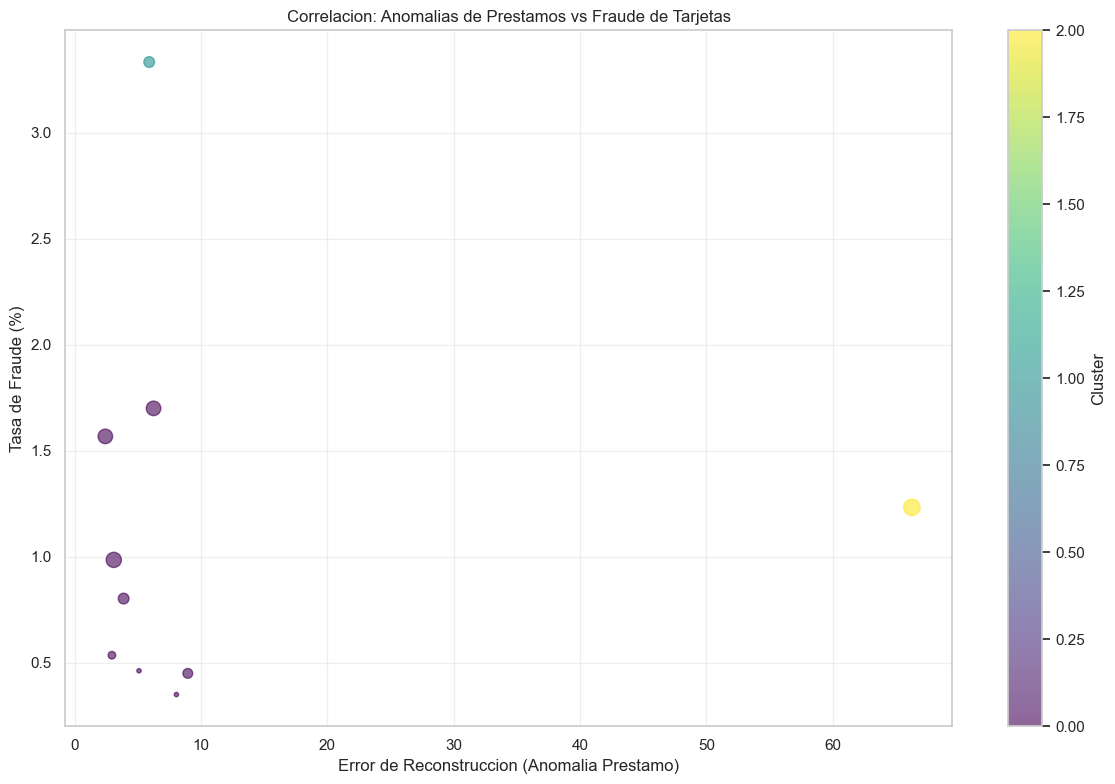

Guardado: matriz_correlacion.png


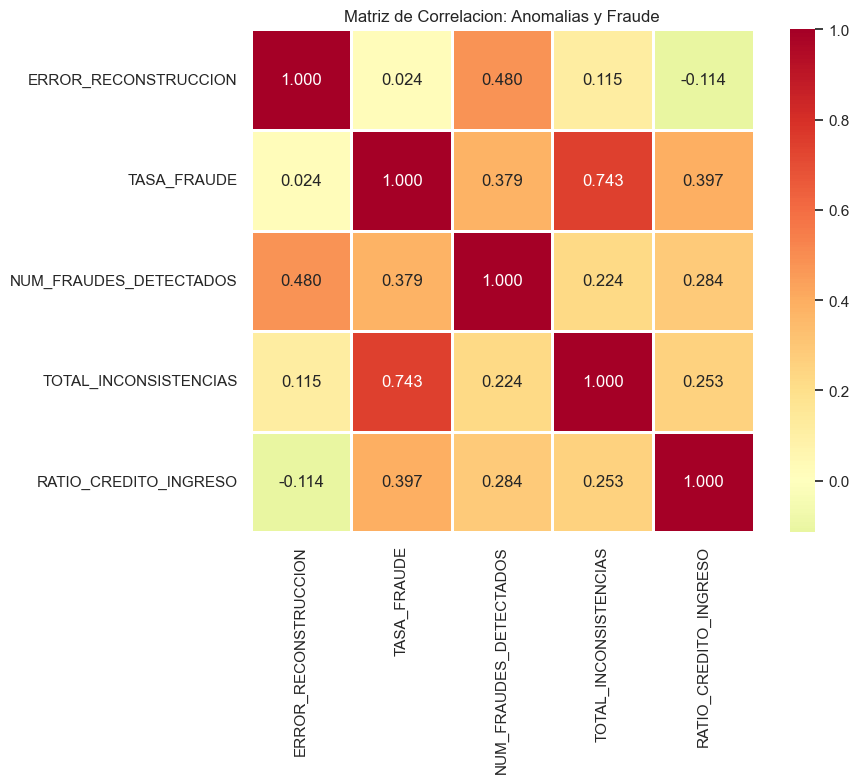

Guardado: fraude_por_anomalia.png


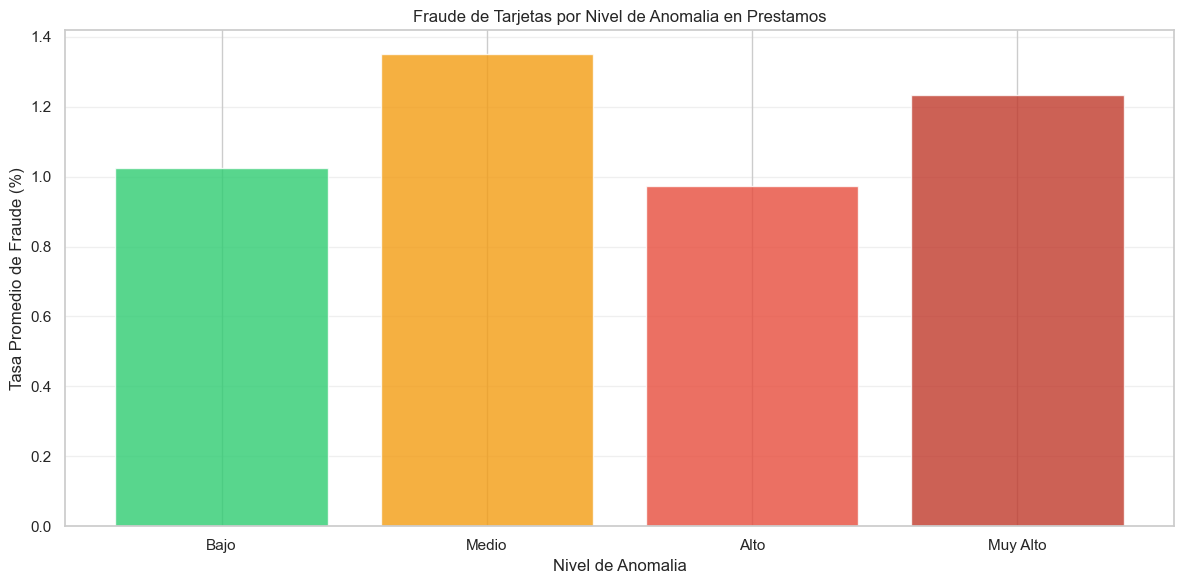

Guardado: comparacion_fraude.png


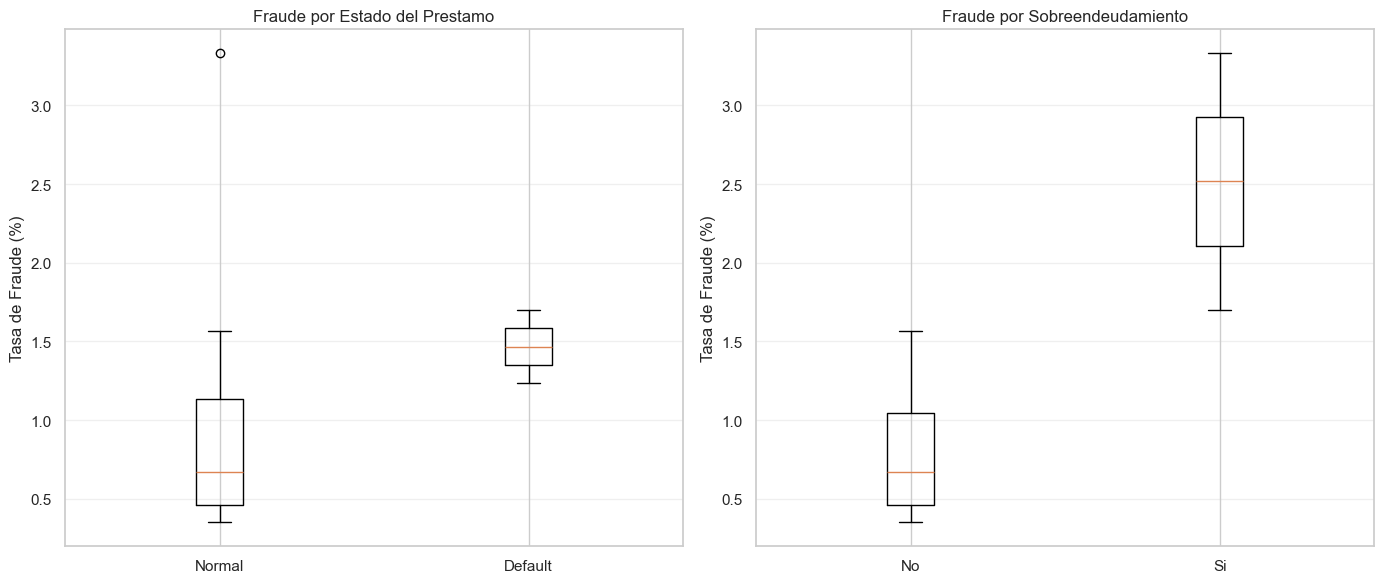

In [ ]:
# Visualizaciones
# 1. Scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(resumen_clientes['ERROR_RECONSTRUCCION'], 
                     resumen_clientes['TASA_FRAUDE'],
                     c=resumen_clientes['CLUSTER'], 
                     s=resumen_clientes['NUM_FRAUDES_DETECTADOS']*10,
                     alpha=0.6, cmap='viridis')
plt.xlabel('Error de Reconstruccion (Anomalia Prestamo)')
plt.ylabel('Tasa de Fraude (%)')
plt.title('Correlacion: Anomalias de Prestamos vs Fraude de Tarjetas')
plt.colorbar(scatter, label='Cluster')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlaciones, annot=True, fmt='.3f', cmap='RdYlGn_r', 
            center=0, square=True, linewidths=1)
plt.title('Matriz de Correlacion: Anomalias y Fraude')
plt.tight_layout()
plt.show()

# 3. Bar plot por nivel de anomalia
bins_anomalia = pd.qcut(df_correlacion['ERROR_RECONSTRUCCION'], q=4, 
                        labels=['Bajo', 'Medio', 'Alto', 'Muy Alto'])
df_correlacion['NIVEL_ANOMALIA'] = bins_anomalia

datos_grouped = df_correlacion.groupby('NIVEL_ANOMALIA')['TASA_FRAUDE'].mean()
plt.figure(figsize=(12, 6))
plt.bar(range(len(datos_grouped)), datos_grouped.values, 
        color=['#2ecc71', '#f39c12', '#e74c3c', '#c0392b'], alpha=0.8)
plt.xlabel('Nivel de Anomalia')
plt.ylabel('Tasa Promedio de Fraude (%)')
plt.title('Fraude de Tarjetas por Nivel de Anomalia en Prestamos')
plt.xticks(range(len(datos_grouped)), datos_grouped.index)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Box plots comparativos
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].boxplot([resumen_clientes[resumen_clientes['TARGET_PRESTAMO']==0]['TASA_FRAUDE'],
                 resumen_clientes[resumen_clientes['TARGET_PRESTAMO']==1]['TASA_FRAUDE']],
                labels=['Normal', 'Default'])
axes[0].set_ylabel('Tasa de Fraude (%)')
axes[0].set_title('Fraude por Estado del Prestamo')
axes[0].grid(axis='y', alpha=0.3)

axes[1].boxplot([resumen_clientes[resumen_clientes['SOBREENDEUDAMIENTO']==0]['TASA_FRAUDE'],
                 resumen_clientes[resumen_clientes['SOBREENDEUDAMIENTO']==1]['TASA_FRAUDE']],
                labels=['No', 'Si'])
axes[1].set_ylabel('Tasa de Fraude (%)')
axes[1].set_title('Fraude por Sobreendeudamiento')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Clientes comunes: 86905


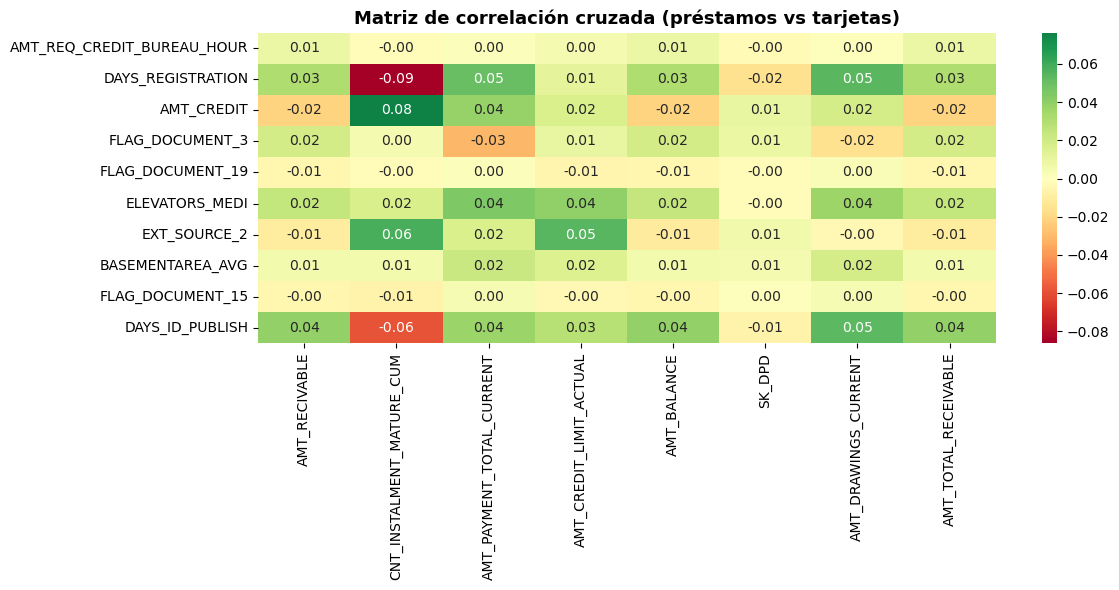

In [ ]:
# MATRIZ DE CORRELACIÓN CRUZADA (PRÉSTAMO–TARJETA)

if "SK_ID_CURR" in loan.columns and "SK_ID_CURR" in credit.columns:
    credit_num = credit.select_dtypes(include=[np.number])
    credit_agg = credit_num.groupby("SK_ID_CURR").mean().reset_index()
    merged = pd.merge(loan, credit_agg, on="SK_ID_CURR", how="inner")
    print("Clientes comunes:", len(merged))

    num_cols_loan = loan.select_dtypes(include=[np.number]).columns
    num_cols_credit = [c for c in credit_agg.columns if c != "SK_ID_CURR"]

    np.random.seed(42)
    muestra_cols_loan = np.random.choice(num_cols_loan, min(10, len(num_cols_loan)), replace=False)
    muestra_cols_credit = np.random.choice(num_cols_credit, min(8, len(num_cols_credit)), replace=False)

    muestra_corr = merged[list(muestra_cols_loan) + list(muestra_cols_credit)]
    corr = muestra_corr.corr().iloc[:len(muestra_cols_loan), len(muestra_cols_loan):]

    plt.figure(figsize=(12, 6))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdYlGn", center=0)
    plt.title("Matriz de correlación cruzada (préstamos vs tarjetas)", fontsize=13, fontweight="bold")
    plt.tight_layout()
    plt.show()

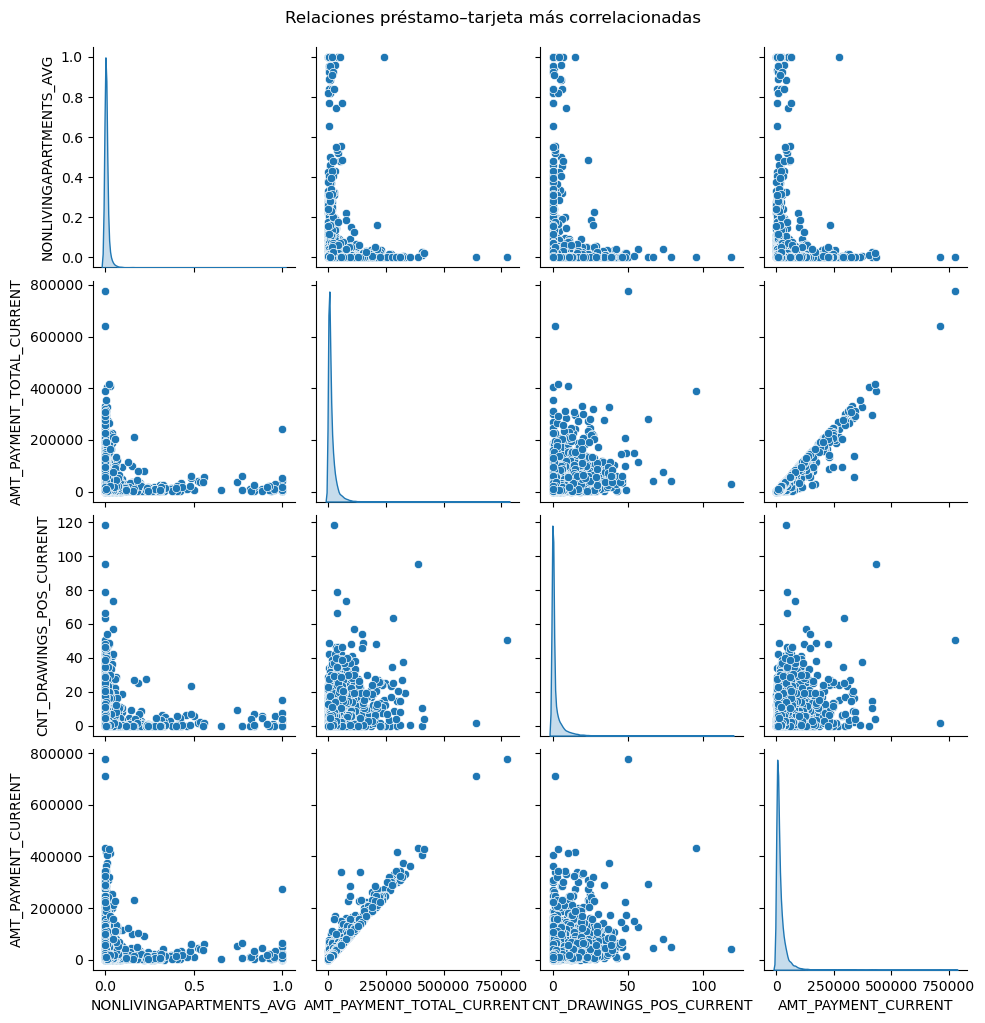

In [ ]:
# RELACIONES PRÉSTAMO–TARJETA

bridge = merged[[
    "SK_ID_CURR", "NONLIVINGAPARTMENTS_AVG",
    "AMT_PAYMENT_TOTAL_CURRENT", "CNT_DRAWINGS_POS_CURRENT",
    "AMT_PAYMENT_CURRENT", "AMT_CREDIT_LIMIT_ACTUAL"
]].dropna()

sns.pairplot(
    bridge[["NONLIVINGAPARTMENTS_AVG", "AMT_PAYMENT_TOTAL_CURRENT",
            "CNT_DRAWINGS_POS_CURRENT", "AMT_PAYMENT_CURRENT"]],
    diag_kind="kde"
)
plt.suptitle("Relaciones préstamo–tarjeta más correlacionadas", y=1.02)
plt.show()

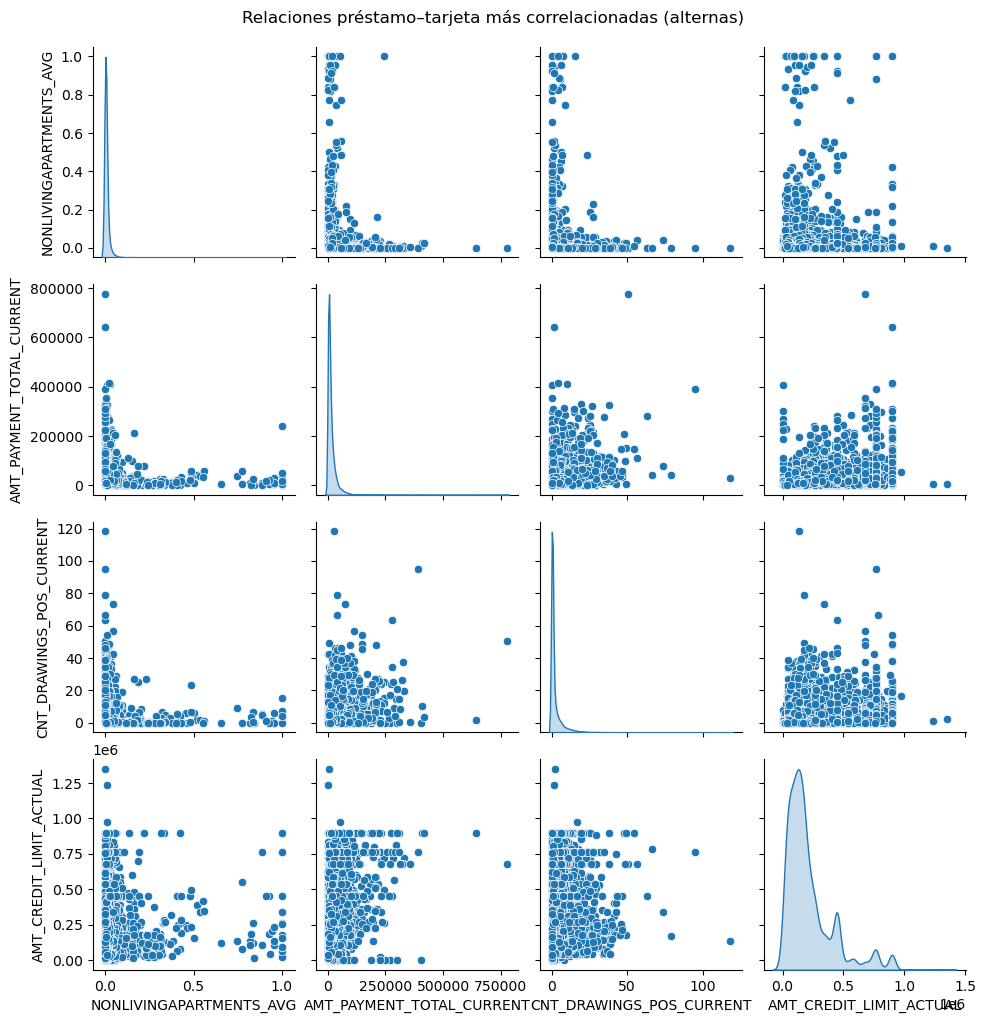

In [ ]:
# RELACIONES PRÉSTAMO–TARJETA (PAIRPLOT ALTERNO)

sns.pairplot(
    bridge[["NONLIVINGAPARTMENTS_AVG", "AMT_PAYMENT_TOTAL_CURRENT",
            "CNT_DRAWINGS_POS_CURRENT", "AMT_CREDIT_LIMIT_ACTUAL"]],
    diag_kind="kde"
)
plt.suptitle("Relaciones préstamo–tarjeta más correlacionadas (alternas)", y=1.02)
plt.show()

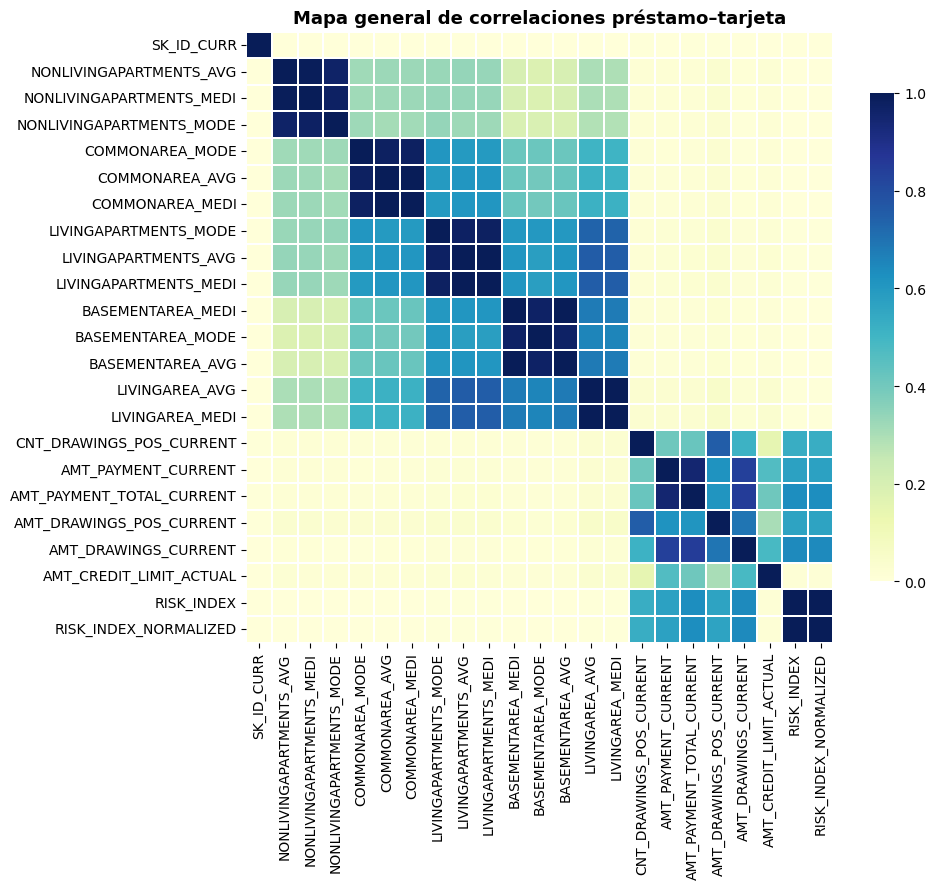

In [23]:
# MAPA GENERAL DE CORRELACIONES

# Índices de riesgo
den = merged["AMT_CREDIT_LIMIT_ACTUAL"].replace(0, np.nan)
merged["RISK_INDEX"] = ((merged["AMT_PAYMENT_CURRENT"].fillna(0) +
                         merged["AMT_DRAWINGS_CURRENT"].fillna(0)) / den).replace([np.inf, -np.inf], np.nan).fillna(0)
rng = merged["RISK_INDEX"].max() - merged["RISK_INDEX"].min()
merged["RISK_INDEX_NORMALIZED"] = (merged["RISK_INDEX"] - merged["RISK_INDEX"].min()) / rng if rng != 0 else 0

# Columnas seleccionadas
cols_corr = [
    "SK_ID_CURR",
    "NONLIVINGAPARTMENTS_AVG","NONLIVINGAPARTMENTS_MEDI","NONLIVINGAPARTMENTS_MODE",
    "COMMONAREA_MODE","COMMONAREA_AVG","COMMONAREA_MEDI",
    "LIVINGAPARTMENTS_MODE","LIVINGAPARTMENTS_AVG","LIVINGAPARTMENTS_MEDI",
    "BASEMENTAREA_MEDI","BASEMENTAREA_MODE","BASEMENTAREA_AVG",
    "LIVINGAREA_AVG","LIVINGAREA_MEDI",
    "CNT_DRAWINGS_POS_CURRENT",
    "AMT_PAYMENT_CURRENT","AMT_PAYMENT_TOTAL_CURRENT",
    "AMT_DRAWINGS_POS_CURRENT","AMT_DRAWINGS_CURRENT",
    "AMT_CREDIT_LIMIT_ACTUAL",
    "RISK_INDEX","RISK_INDEX_NORMALIZED"
]
cols = [c for c in cols_corr if c in merged.columns]
df = merged[cols].copy()

# Limpieza y normalización
for c in df.columns:
    df[c] = df[c].fillna(df[c].median())
    df[c] = np.array(winsorize(df[c].to_numpy(), limits=[0.01, 0.01]))

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Correlación Pearson
corr_bridge = df_scaled.corr(method="pearson").abs()

plt.figure(figsize=(10, 9))
sns.heatmap(
    corr_bridge, cmap="YlGnBu", vmin=0, vmax=1,
    linewidths=0.1, linecolor="white", cbar_kws={"shrink": 0.8}
)
plt.title("Mapa general de correlaciones préstamo–tarjeta", fontsize=13, fontweight="bold")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()